In [1]:
import gym
from gym import spaces, logger
from gym.utils import seeding

import numpy as np
import os
import random
import math
import pylab
import matplotlib.pyplot as plt

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.losses import huber_loss
from keras import backend as K

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


In [0]:
class CartPoleEnv(gym.Env):
	metadata = {
			'render.modes': ['human', 'rgb_array'],
			'video.frames_per_second' : 50
	}

	def __init__(self,case=1):
		self.__version__ = "0.2.0"
		print("CartPoleEnv - Version {}, Noise case: {}".format(self.__version__,case))
		self.gravity = 9.8
		self.masscart = 1.0
		self.masspole = 0.4
		self.total_mass = (self.masspole + self.masscart)
		self.length = 0.5 
		self.polemass_length = (self.masspole * self.length)
		self._seed()

		#self.force_mag = 10.0
		self.force_mag = 10.0*(1+self.np_random.uniform(low=-0.30, high=0.30))

		 
		self.tau = 0.02  # seconds between state updates
		self.frictioncart = 5e-4 # AA Added cart friction
		self.frictionpole = 2e-6 # AA Added cart friction
		self.gravity_eps = 0.99 # Random scaling for gravity
		self.frictioncart_eps = 0.99 # Random scaling for friction
		self.frictionpole_eps = 0.99 # Random scaling for friction

		# Angle at which to fail the episode
		self.theta_threshold_radians = 12 * 2 * math.pi / 360
		self.x_threshold = 2.4

		# Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
		high = np.array([
			self.x_threshold * 2,
			np.finfo(np.float32).max,
			self.theta_threshold_radians * 2,
			np.finfo(np.float32).max])

		self.action_space = spaces.Discrete(2) # AA Set discrete states back to 2
		self.observation_space = spaces.Box(-high, high)

		self.viewer = None
		self.state = None

		self.steps_beyond_done = None

	def _seed(self, seed=None): # Set appropriate seed value
		self.np_random, seed = seeding.np_random(seed)
		return [seed]

	def _step(self, action):
		assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
		state = self.state
		x, x_dot, theta, theta_dot = state
		force = self.force_mag if action==1 else -self.force_mag
		costheta = math.cos(theta)
		sintheta = math.sin(theta)
		temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta - self.frictioncart * (4 + self.frictioncart_eps*np.random.randn()) *np.sign(x_dot)) / self.total_mass # AA Added cart friction
		thetaacc = (self.gravity * (4 + self.gravity_eps*np.random.randn()) * sintheta - costheta* temp - self.frictionpole * (4 + self.frictionpole_eps*np.random.randn()) *theta_dot/self.polemass_length) / (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass)) # AA Added pole friction
		xacc  = temp - self.polemass_length * thetaacc * costheta / self.total_mass
		#noise = 0
		noise = self.np_random.uniform(low=-0.30, high=0.30) 
		x  = (x + self.tau * x_dot)
		x_dot = (x_dot + self.tau * xacc)
		theta = (theta + self.tau * theta_dot)*(1 + noise)
		theta_dot = (theta_dot + self.tau * thetaacc)
		self.state = (x,x_dot,theta,theta_dot)
		done =  x < -self.x_threshold \
				or x > self.x_threshold \
				or theta < -self.theta_threshold_radians \
				or theta > self.theta_threshold_radians
		done = bool(done)

		if not done:
			reward = 1.0
		elif self.steps_beyond_done is None:
			# Pole just fell!
			self.steps_beyond_done = 0
			reward = 1.0
		else:
			if self.steps_beyond_done == 0:
				logger.warning("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
			self.steps_beyond_done += 1
			reward = 0.0

		return np.array(self.state), reward, done, {}

	def _reset(self):
		self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
		self.steps_beyond_done = None
		return np.array(self.state)

	def _render(self, mode='human', close=False):
		if close:
			if self.viewer is not None:
				self.viewer.close()
				self.viewer = None
			return

		screen_width = 600
		screen_height = 400

		world_width = self.x_threshold*2
		scale = screen_width/world_width
		carty = 100 # TOP OF CART
		polewidth = 10.0
		polelen = scale * 1.0
		cartwidth = 50.0
		cartheight = 30.0

		if self.viewer is None:
			from gym.envs.classic_control import rendering
			self.viewer = rendering.Viewer(screen_width, screen_height)
			l,r,t,b = -cartwidth/2, cartwidth/2, cartheight/2, -cartheight/2
			axleoffset =cartheight/4.0
			cart = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
			self.carttrans = rendering.Transform()
			cart.add_attr(self.carttrans)
			self.viewer.add_geom(cart)
			l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
			pole = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
			pole.set_color(.8,.6,.4)
			self.poletrans = rendering.Transform(translation=(0, axleoffset))
			pole.add_attr(self.poletrans)
			pole.add_attr(self.carttrans)
			self.viewer.add_geom(pole)
			self.axle = rendering.make_circle(polewidth/2)
			self.axle.add_attr(self.poletrans)
			self.axle.add_attr(self.carttrans)
			self.axle.set_color(.5,.5,.8)
			self.viewer.add_geom(self.axle)
			self.track = rendering.Line((0,carty), (screen_width,carty))
			self.track.set_color(0,0,0)
			self.viewer.add_geom(self.track)

		if self.state is None: return None

		x = self.state
		cartx = x[0]*scale+screen_width/2.0 # MIDDLE OF CART
		self.carttrans.set_translation(cartx, carty)
		self.poletrans.set_rotation(-x[2])
		return self.viewer.render(return_rgb_array = mode=='rgb_array')

In [0]:
class DDQNAgent():
  def __init__(self,env, max_timesteps_per_episode=500, episodes=1000, soft_update=False, tau=0.1, seed=42, gamma=0.99, eps=1.0, eps_min=1e-3, eps_decay=0.99, batch_size=64, train_start=1000):
    self.env = env
    self.env._seed = seed
    self.gamma = gamma #discount factor
    self.eps = eps #exploration rate
    self.eps_min = eps_min
    self.eps_decay = eps_decay
    self.batch_size = batch_size
    self.train_start = train_start
    self.episodes = episodes
    self.max_timesteps_per_episode = max_timesteps_per_episode
    self.soft_update = soft_update
    self.tau = tau

    self.buffer = []
    self.obs_dim, self.act_dim = self.env.observation_space.shape[0], self.env.action_space.n
    self.current_model = self.create_model((self.obs_dim,), self.act_dim)
    self.target_model = self.create_model((self.obs_dim,), self.act_dim)
    self.update_target_model()

    self.scores, self.episodes_arr, self.average, self.average_last_100 = [], [], [], []

  def create_model(self, obs_dim, act_dim):
    ip = Input(shape=obs_dim)
    x = Dense(4, input_shape=obs_dim, activation='relu', kernel_initializer='he_uniform')(ip)
    x = Dense(4, activation='relu', kernel_initializer='he_uniform')(x)
    op = Dense(act_dim, activation='linear', kernel_initializer='he_uniform')(x)

    model = Model(inputs=ip, outputs=op, name='CP_task3_DDQN')
    model.compile(loss='mse', optimizer=Adam(lr=1e-3))

    return model

  def update_target_model(self):
    if self.soft_update:
      current_params = self.current_model.get_weights()
      target_params = self.target_model.get_weights()
      i=0
      for current_param, target_param in zip(current_params, target_params):
        target_params[i] = (1-self.tau)*target_param + self.tau*current_param
        i+=1
      self.target_model.set_weights(target_params)

    else:  
      self.target_model.set_weights(self.current_model.get_weights())

  def decay_schedule(self):
    if len(self.buffer) > self.train_start:
      self.eps = np.clip(self.eps*self.eps_decay, self.eps_min, 1.0)

  def act(self, obs):
    if np.random.random() <= self.eps:
      return random.randrange(self.act_dim)
    return np.argmax(self.current_model.predict(obs))

  def replay(self):
    if len(self.buffer) > self.train_start:
      batch = random.sample(self.buffer, self.batch_size)
      states, next_states = np.zeros((self.batch_size, self.obs_dim)), np.zeros((self.batch_size, self.obs_dim))
      actions, rewards, dones = [], [], []
      
      for i in range(len(batch)):
        states[i] = batch[i][0]
        actions.append(batch[i][1])
        rewards.append(batch[i][2])
        next_states[i] = batch[i][3]
        dones.append(batch[i][4])

      targets = self.current_model.predict(states)
      next_targets = self.current_model.predict(next_states)
      next_targets_from_target = self.target_model.predict(next_states)

      for i in range(len(batch)):
        action = np.argmax(next_targets[i])
        targets[i][actions[i]] = rewards[i] + (1-dones[i])*self.gamma*next_targets_from_target[i][action]

      self.current_model.fit(states, targets, batch_size=len(batch), verbose=0)

      self.decay_schedule()
      
  def train(self):
    best_reward = 0.0
    best_ep_reward = 0.0
    scores_arr = []
    
    for episode in range(self.episodes):
      state, done = self.env._reset(), 0
      ep_reward = 0
      
      for step in range(self.max_timesteps_per_episode):
        state = state.reshape((1, self.obs_dim))
        action = self.act(state)
        next_state, reward, done, _ = self.env._step(action)
        ep_reward += reward

        self.buffer.append((state, action, reward, next_state, done))
        state = next_state

        if done:
          self.update_target_model()
          break
          
        self.replay()

      #Recording for plotting the model
      self.scores.append(ep_reward)
      self.episodes_arr.append(episode)
      self.average.append(sum(self.scores)/len(self.scores))
      self.average_last_100.append(round(np.mean(self.scores[-100:]),1))

      scores_arr.append(ep_reward)
      mean_100_rew = round(np.mean(scores_arr[-100:]),1)
      
      print("Episode: {} | Episode reward: {} | Mean of last 100 episodes: {} | eps: {:.2}".format(episode, ep_reward, mean_100_rew, self.eps))
      
      if ep_reward > best_ep_reward:
        best_ep_reward = ep_reward
        print("Acheived the max score possible for an episode!")
        self.current_model.save('best_for_episode_dqn.h5')

      if mean_100_rew > best_reward:
        best_reward = mean_100_rew
        print("Achieved a better mean of {}!".format(best_reward))
        self.current_model.save('best_mean_dqn.h5')
        
      if mean_100_rew >= self.max_timesteps_per_episode:
        print("Achieved mean score greater than 500 in the last 100 episodes!")
        self.current_model.save('best_mean_500_dqn.h5')
        return 

  def evaluate(self, num_episodes=100, num_timesteps=500, model=None):
    scores_arr = []

    for i in range(num_episodes):
      ep_reward = 0
      obs = env._reset()
      for t in range(num_timesteps):
        obs = np.reshape(obs, (1, 4))
        act = np.argmax(model.predict(obs))
        next_state, reward, done, _ = env._step(act)
        ep_reward += reward
        
        if done:
          break

        obs = next_state

      scores_arr.append(ep_reward)
        
    print("Mean over 100 episodes: {}".format(round(np.mean(scores_arr),1)))
    
    return round(np.mean(scores_arr),1)


In [4]:
env = CartPoleEnv()
agent = DDQNAgent(env, episodes=1500, max_timesteps_per_episode=500, tau=0.9, soft_update=True, eps_decay=0.999)
agent.train()

CartPoleEnv - Version 0.2.0, Noise case: 1
Episode: 0 | Episode reward: 18.0 | Mean of last 100 episodes: 18.0 | eps: 1.0
Acheived the max score possible for an episode!
Achieved a better mean of 18.0!
Episode: 1 | Episode reward: 23.0 | Mean of last 100 episodes: 20.5 | eps: 1.0
Acheived the max score possible for an episode!
Achieved a better mean of 20.5!
Episode: 2 | Episode reward: 15.0 | Mean of last 100 episodes: 18.7 | eps: 1.0
Episode: 3 | Episode reward: 27.0 | Mean of last 100 episodes: 20.8 | eps: 1.0
Acheived the max score possible for an episode!
Achieved a better mean of 20.8!
Episode: 4 | Episode reward: 18.0 | Mean of last 100 episodes: 20.2 | eps: 1.0
Episode: 5 | Episode reward: 12.0 | Mean of last 100 episodes: 18.8 | eps: 1.0
Episode: 6 | Episode reward: 12.0 | Mean of last 100 episodes: 17.9 | eps: 1.0
Episode: 7 | Episode reward: 12.0 | Mean of last 100 episodes: 17.1 | eps: 1.0
Episode: 8 | Episode reward: 14.0 | Mean of last 100 episodes: 16.8 | eps: 1.0
Episod

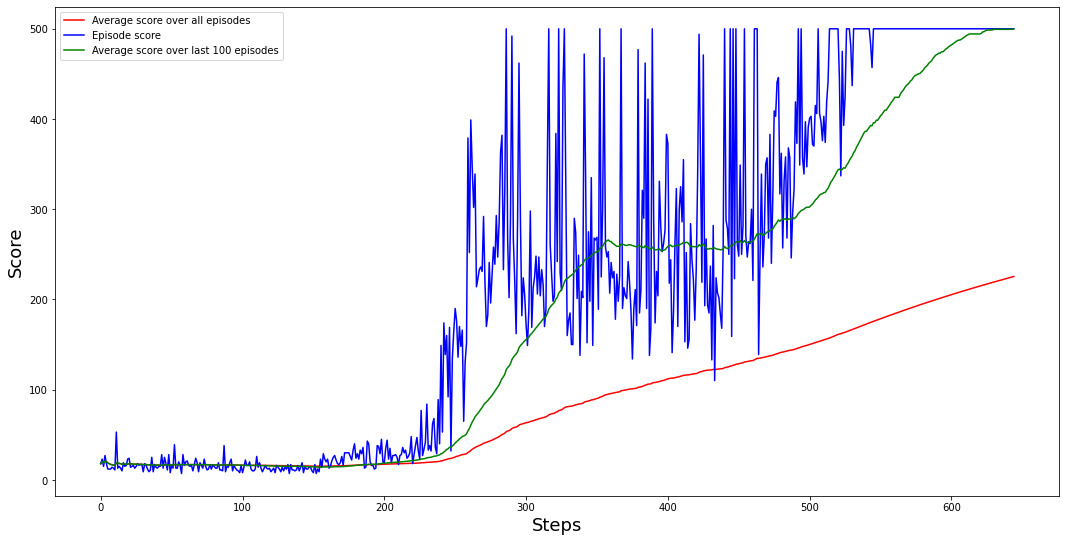

In [5]:
  import matplotlib.pyplot as plt

  plt.figure(figsize=(18, 9))
  plt.plot(agent.episodes_arr, agent.average, 'r', label='Average score over all episodes')
  plt.plot(agent.episodes_arr, agent.scores, 'b', label='Episode score')
  plt.plot(agent.episodes_arr, agent.average_last_100, 'g', label='Average score over last 100 episodes')
  plt.ylabel('Score', fontsize=18)
  plt.xlabel('Steps', fontsize=18)
  plt.legend()
  plt.savefig('best_train_plot.png')

In [6]:
num_episodes = 100
num_timesteps = 500

env = CartPoleEnv()
# env = gym.make('CartPole-v1')
model = load_model('/content/best_mean_500_dqn.h5')

scores_arr = []

for i in range(num_episodes):
  ep_reward = 0
  obs = env._reset()
  for t in range(num_timesteps):
    obs = np.reshape(obs, (1, 4))
    act = np.argmax(model.predict(obs))
    next_state, reward, done, _ = env._step(act)
    ep_reward += reward
    
    if done:
      break

    obs = next_state

  scores_arr.append(ep_reward)
    
print("Mean over 100 episodes: {}".format(round(np.mean(scores_arr),1)))

CartPoleEnv - Version 0.2.0, Noise case: 1
Mean over 100 episodes: 500.0


In [0]:
for i in range(10):
  agent.evaluate(model=load_model('/content/best_mean_500_dqn.h5'))

Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
Mean over 100 episodes: 500.0
